In [1]:
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision
import functools
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchvision.utils import save_image
# from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, random_split

import time
from sklearn.model_selection import train_test_split
import pylab as pl
from IPython import display
import logging
import os
import shutil
import sys
import torch.nn as nn
import tempfile
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import torch
from urllib.request import urlretrieve
import gzip
from PIL import Image
import pathlib
from pathlib import Path
import pandas as pd
from IPython.display import clear_output

In [13]:
data_directory = "/beegfs/home/ruslan.kalimullin/fMRI_generative_models/data_77"

In [14]:
class FMRIConnectivityDataset(Dataset):
    def __init__(self, data_directory, ids, transform=None):
        self.transform = transform
        self.data = [] 

        for subject_id in ids:
            rest_file_path = os.path.join(data_directory, f"{subject_id}_rfMRI_REST1_LR.csv")
            motor_file_path = os.path.join(data_directory, f"{subject_id}_tfMRI_MOTOR_LR.csv")

            if os.path.exists(rest_file_path) and os.path.exists(motor_file_path):
                rest_data = pd.read_csv(rest_file_path)
                motor_data = pd.read_csv(motor_file_path)

                self.data.append((subject_id, rest_data.values, motor_data.values))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        subject_id, rest_fMRI_matrix, motor_task_fMRI_matrix = self.data[idx]

        data_dict = {
            "subject_id": subject_id,
            "rest_fMRI_data": torch.FloatTensor(rest_fMRI_matrix[np.newaxis,:,:]),
            "motor_task_fMRI_data": torch.FloatTensor(motor_task_fMRI_matrix[np.newaxis,:,:])
        }

        return data_dict

In [15]:
file_names = [f for f in os.listdir(data_directory) if f.endswith(".csv")]

file_ids = list(set([file.split('_')[0] for file in file_names]))  

train_ratio = 0.8
test_ratio = 0.2

train_ids, remaining_ids = train_test_split(file_ids, test_size=test_ratio, random_state=1380)
test_ids = remaining_ids 

train_dataset = FMRIConnectivityDataset(data_directory, train_ids)
test_dataset = FMRIConnectivityDataset(data_directory, test_ids)

batch_size = 10
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [5]:
# custom weights initialization called on generator and discriminator        
def weights_init(net, init_type='normal', scaling=0.02):
    """Initialize network weights.
    Parameters:
        net (network)   -- network to be initialized
        init_type (str) -- the name of an initialization method: normal | xavier | kaiming | orthogonal
        init_gain (float)    -- scaling factor for normal, xavier and orthogonal.
    We use 'normal' in the original pix2pix and CycleGAN paper. But xavier and kaiming might
    work better for some applications. Feel free to try yourself.
    """
    def init_func(m):  # define the initialization function
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv')) != -1:
            torch.nn.init.normal_(m.weight.data, 0.0, scaling)
        elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
            torch.nn.init.normal_(m.weight.data, 1.0, scaling)
            torch.nn.init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)  # apply the initialization function <init_func>
def get_norm_layer():
    """Return a normalization layer
       For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
    """
    norm_type = 'batch'
    if norm_type == 'batch':
        norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
    return norm_layer
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, nf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            nf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        
        # add intermediate layers with ngf * 8 filters
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        unet_block = UnetSkipConnectionBlock(nf * 8, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        
        # gradually reduce the number of filters from nf * 8 to nf
        unet_block = UnetSkipConnectionBlock(nf * 4, nf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf * 2, nf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(nf, nf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, nf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)
class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
class UnetSkipConnectionBlock(nn.Module):
    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if input_nc is None:
            input_nc = outer_nc

        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=3, stride=1, padding=1, bias=False)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)

        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            # Modify the kernel size for the outermost upconv layer
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc,
                                        kernel_size=3, stride=1, padding=1)  # Adjusted kernel_size and stride
            down = [downconv]
            up = [uprelu, upconv, nn.Tanh()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=3, stride=1,
                                        padding=1, bias=False)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc*2, outer_nc,
                                        kernel_size=3, stride=1,
                                        padding=1, bias=False)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            model_x = self.model(x)
            # print("x size:", x.size())
            # print("model_x size:", model_x.size())
            return torch.cat([x, model_x], 1)
device = 'cuda:0'
norm_layer = get_norm_layer()


# Create the generator
generator = UnetGenerator(1, 1, 64, norm_layer=norm_layer, use_dropout=False)
generator.apply(lambda x: weights_init(x, init_type='normal', scaling=0.02))
generator = generator.to(device)
#generator = torch.nn.DataParallel(generator)
inp = torch.ones(10, 1, 77, 77)
inp = inp.to(device)

# Debug 
print("Input Tensor Size:", inp.size())

# Generate output
gen = generator(inp)

# Debug 
print("Generated Tensor Size:", gen.size())

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initiali

In [6]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw), nn.Sigmoid()]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)
discriminator = Discriminator(2, 64, n_layers=3, norm_layer=norm_layer)#.cuda().float()
discriminator.apply(weights_init)
#discriminator = torch.nn.DataParallel(discriminator)  # multi-GPUs
discriminator=discriminator.cuda()
inp = torch.ones(10,2,77,77).cuda()
disc = discriminator(inp)
disc.shape

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


torch.Size([10, 1, 7, 7])

In [7]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (25 * l1_l)
    #print(gen_loss)
    return gen_total_loss
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss
def discriminator_wasserstein_loss(real_output, generated_output):
    return torch.mean(real_output) - torch.mean(generated_output)
learning_rate = 2e-4 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.9, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.9, 0.999))

In [10]:
discriminator.load_state_dict(torch.load('/beegfs/home/ruslan.kalimullin/fMRI_generative_models/Weights/Wasserstein_discriminator_1-D_fixed_data_223+77.pth'))
generator.load_state_dict(torch.load('/beegfs/home/ruslan.kalimullin/fMRI_generative_models/Weights/Wasserstein_generator_1-D_fixed_data_223+77.pth'))

/tmp/ipykernel_631069/523990676.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  discriminator.load_state_dict(torch.load('/beegfs/home/ruslan.kalimullin/fMRI_generative_

<All keys matched successfully>

In [11]:
# Function to plot original and predicted matrices
def plot_original_and_predicted(rest, original, predicted, title_original_rest, title_original_motor, title_predicted):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Original Rest data
    axes[0].set_title(title_original_rest)
    axes[0].imshow(rest[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[0].axis('off')

    # Original Motor data
    axes[1].set_title(title_original_motor)
    axes[1].imshow(original[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[1].axis('off')
    
      # Predicted data
    axes[2].set_title(title_predicted)
    axes[2].imshow(predicted[0][0].cpu().detach().numpy(), cmap='viridis', interpolation='nearest')
    axes[2].axis('off')
    
    plt.show()


/tmp/ipykernel_631069/2273821671.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_X_test = generator(torch.tensor(rest_batch, device=device)).to(device)


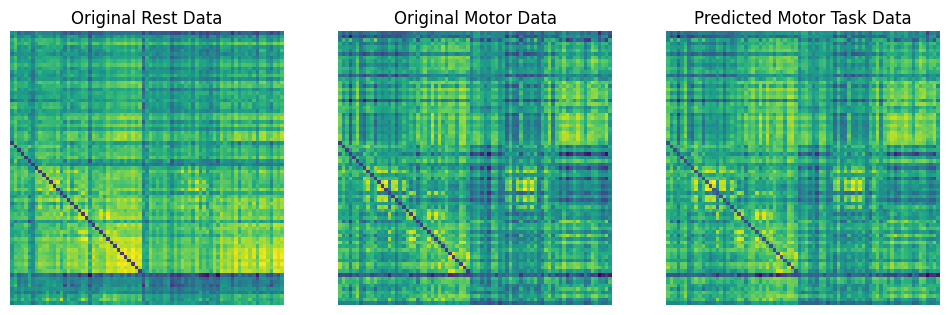

MSE: 0.006034617777913809
L1: 0.04420355707406998


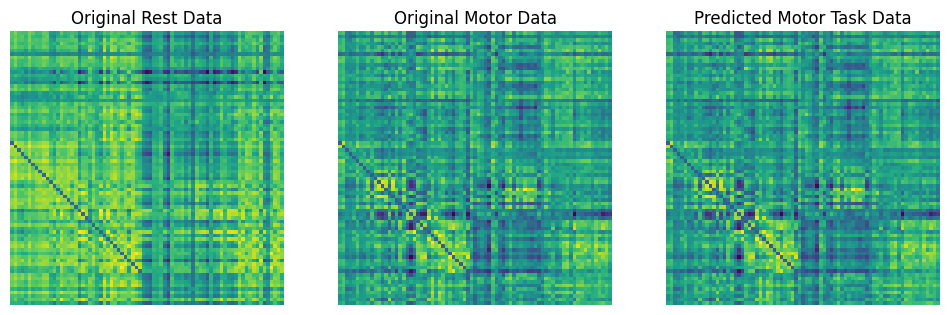

MSE: 0.002400427358224988
L1: 0.03226035088300705


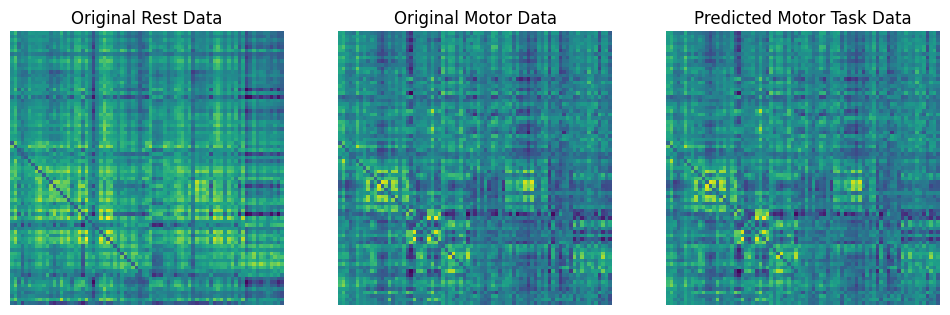

MSE: 0.0036353671457618475
L1: 0.03385479003190994


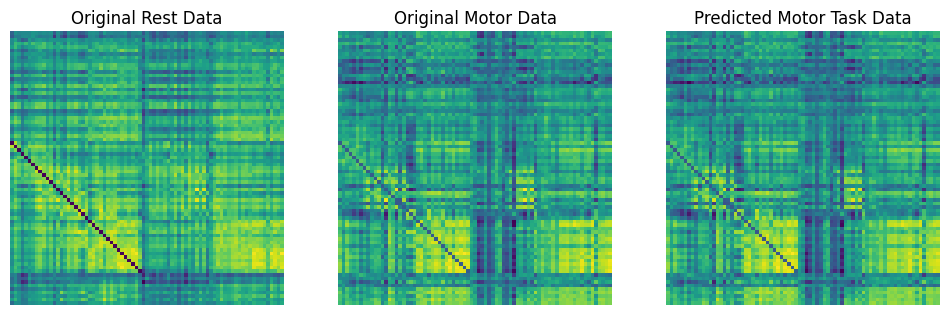

MSE: 0.002902297768741846
L1: 0.03197731077671051


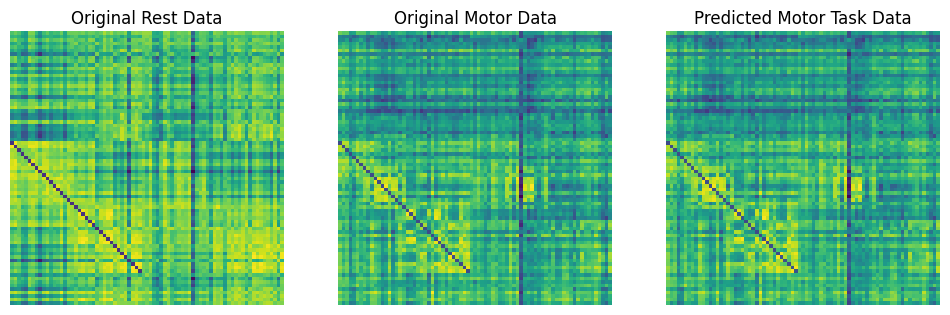

MSE: 0.004221714101731777
L1: 0.034685369580984116


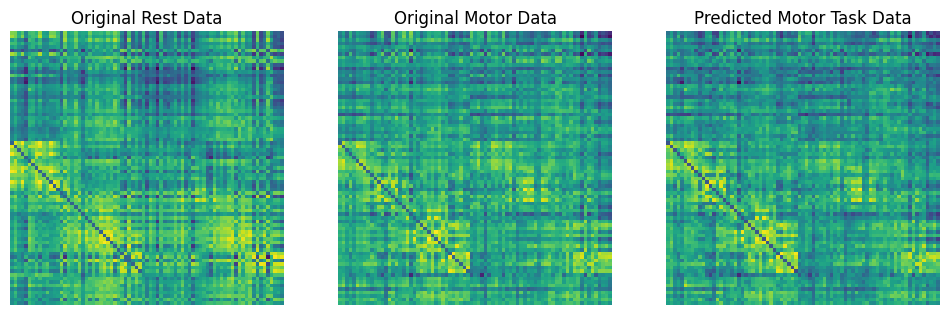

MSE: 0.0018167130183428526
L1: 0.029441267251968384


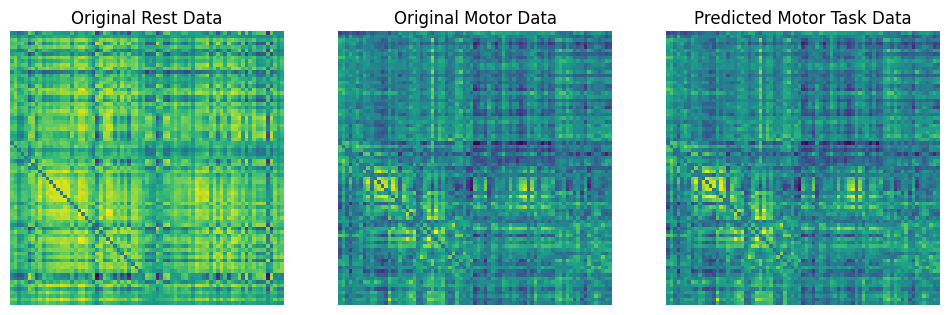

MSE: 0.008570917882025242
L1: 0.04857325926423073


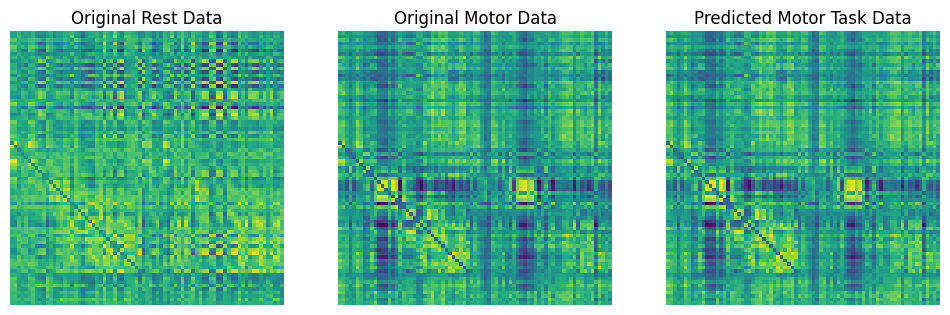

MSE: 0.003914445638656616
L1: 0.03530320152640343


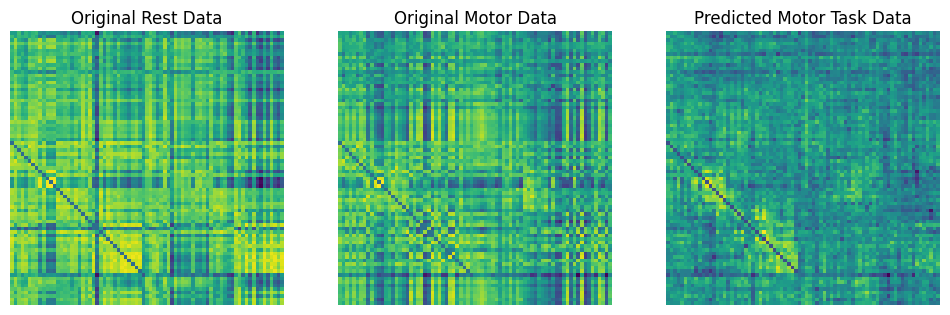

MSE: 0.005687043536454439
L1: 0.044240858405828476


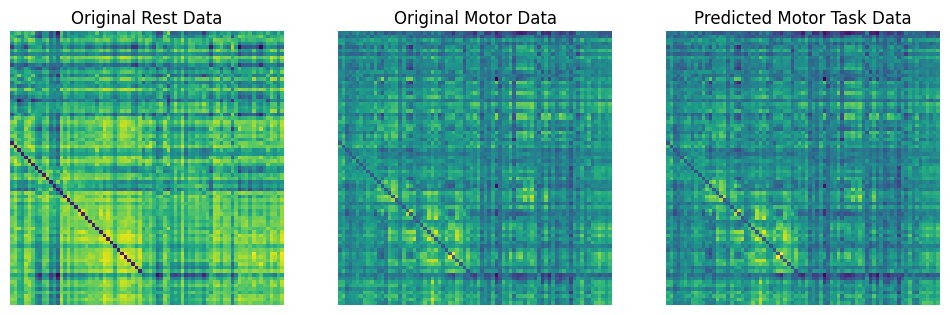

MSE: 0.0024597630836069584
L1: 0.03478466719388962


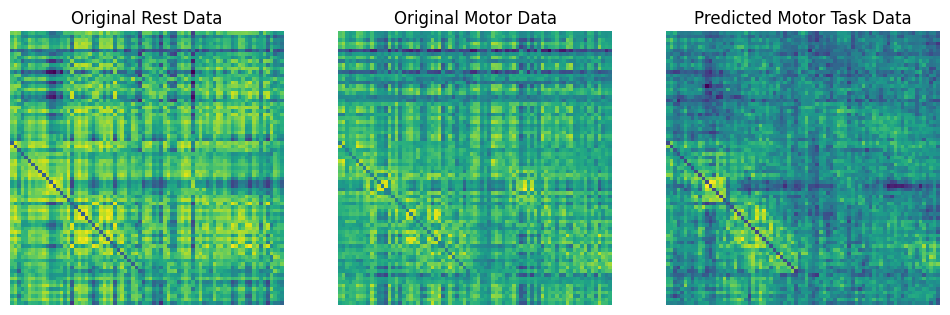

MSE: 0.004736497066915035
L1: 0.03886118531227112


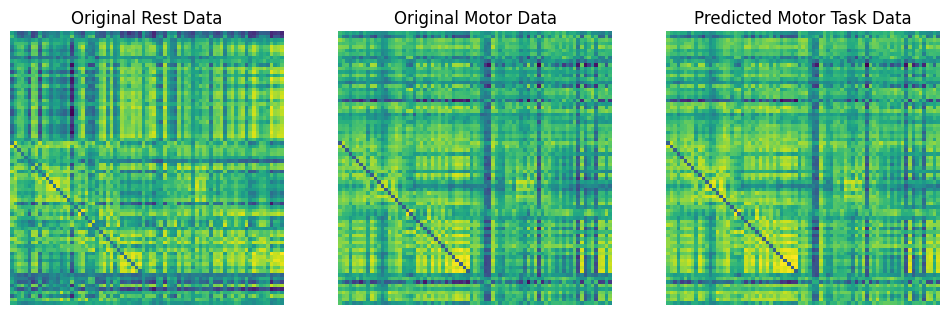

MSE: 0.0014378717169165611
L1: 0.02737412601709366


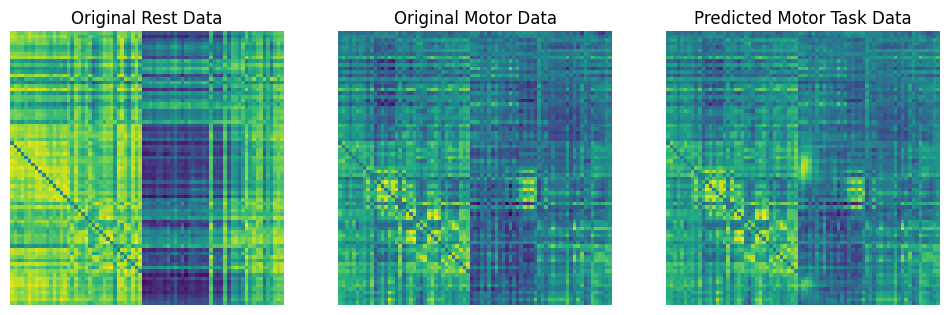

MSE: 0.002742786891758442
L1: 0.03379565104842186


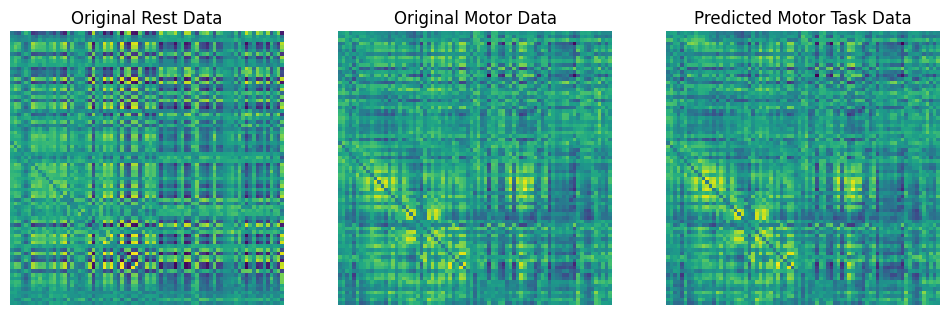

MSE: 0.0013160912785679102
L1: 0.02806794084608555


In [ ]:
mse_loss_motor_all = []
l1_loss_motor_all = []
MSELoss = torch.nn.MSELoss()
L1Loss = torch.nn.L1Loss()

with torch.no_grad():
    for batch_data in test_data_loader:
        rest_batch = batch_data["rest_fMRI_data"].to(device)  # Ensure data is on the same device as your model
        motor_batch = batch_data["motor_task_fMRI_data"].to(device)
        
        # Predict the motor task data
        T_X_test = generator(torch.tensor(rest_batch, device=device)).to(device)
        
        # Calculate the MSE loss
        mse_loss_motor = MSELoss(T_X_test, motor_batch)
        mse_loss_motor_all.append(mse_loss_motor.cpu().detach().numpy())
        
        # Calculate the L1 loss
        l1_loss_motor = L1Loss(T_X_test, motor_batch)
        l1_loss_motor_all.append(l1_loss_motor.cpu().detach().numpy())

        # Plot the original and predicted "motor" task data
        plot_original_and_predicted(rest_batch, motor_batch, T_X_test, 'Original Rest Data', 'Original Motor Data', 'Predicted Motor Task Data')
        
        # Print the losses
        print("MSE:", mse_loss_motor.item())
        print("L1:", l1_loss_motor.item())

In [25]:
import numpy as np

average = np.mean(mse_loss_motor_all)

std_deviation = np.std(mse_loss_motor_all)

print("Mean MSE for NOT with 100 steps:", average)
print("Std for MSE:", std_deviation)

Mean MSE for NOT with 100 steps: 0.0037054683
Std for MSE: 0.0019575416


In [26]:
import numpy as np

average = np.mean(l1_loss_motor_all)

std_deviation = np.std(l1_loss_motor_all)

print("Mean L1 for NOT with 100 steps:", average)
print("Std for L1:", std_deviation)

Mean L1 for NOT with 100 steps: 0.035530254
Std for L1: 0.006106514


In [25]:
adversarial_loss = nn.BCELoss() 
l1_loss = nn.L1Loss()

In [26]:
def generator_loss(generated_image, target_img, G, real_target):
    gen_loss = adversarial_loss(G, real_target)
    l1_l = l1_loss(generated_image, target_img)
    gen_total_loss = gen_loss + (100 * l1_l)
    #print(gen_loss)
    return gen_total_loss

In [27]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [28]:
learning_rate = 2e-4 
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.9, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.9, 0.999))

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_epochs = 300
D_loss_plot, G_loss_plot = [], []
for epoch in range(1, num_epochs+1): 
    D_loss_list, G_loss_list = [], []

    for batch in train_data_loader:
        rest_fMRI_data = batch["rest_fMRI_data"].to(device)
        motor_task_fMRI_data = batch["motor_task_fMRI_data"].to(device)

        D_optimizer.zero_grad()

        generated_image = generator(rest_fMRI_data)

        disc_inp_fake = torch.cat((rest_fMRI_data, generated_image), 1)

        real_target = Variable(torch.ones(rest_fMRI_data.size(0), 1, 7, 7).to(device))
        fake_target = Variable(torch.zeros(rest_fMRI_data.size(0), 1, 7, 7).to(device))

        D_fake = discriminator(disc_inp_fake.detach())
        D_fake_loss = discriminator_loss(D_fake, fake_target)

        disc_inp_real = torch.cat((rest_fMRI_data, motor_task_fMRI_data), 1)
        output = discriminator(disc_inp_real)
        D_real_loss = discriminator_loss(output, real_target)

        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)

        D_total_loss.backward()
        D_optimizer.step()

        G_optimizer.zero_grad()
        fake_gen = torch.cat((rest_fMRI_data, generated_image), 1)
        G = discriminator(fake_gen)
        G_loss = generator_loss(generated_image, motor_task_fMRI_data, G, real_target)                                 
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

    print('Epoch: [%d/%d]: D_loss: %.3f, G_loss: %.3f' % (
            (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)), \
            torch.mean(torch.FloatTensor(G_loss_list))))

    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

#     torch.save(generator.state_dict(), 'torch/training_weights/generator_epoch_%d.pth' % (epoch))
#     torch.save(discriminator.state_dict(), 'torch/training_weights/discriminator_epoch_%d.pth' % (epoch))

#     for batch in val_dl:
#         inputs = batch["rest_fMRI_data"].to(device)
#         generated_output = generator(inputs)
#         save_image(generated_output.data[:10], 'torch/images/sample_%d' % epoch + '.png', nrow=5, normalize=True)


Epoch: [1/300]: D_loss: 0.503, G_loss: 21.211
Epoch: [2/300]: D_loss: 0.265, G_loss: 21.689
Epoch: [3/300]: D_loss: 0.259, G_loss: 22.463
Epoch: [4/300]: D_loss: 0.302, G_loss: 22.569
Epoch: [5/300]: D_loss: 0.330, G_loss: 22.863
Epoch: [6/300]: D_loss: 0.355, G_loss: 22.934
Epoch: [7/300]: D_loss: 0.318, G_loss: 22.820
Epoch: [8/300]: D_loss: 0.336, G_loss: 22.762
Epoch: [9/300]: D_loss: 0.344, G_loss: 22.701
Epoch: [10/300]: D_loss: 0.402, G_loss: 22.276
Epoch: [11/300]: D_loss: 0.364, G_loss: 22.416
Epoch: [12/300]: D_loss: 0.373, G_loss: 22.296
Epoch: [13/300]: D_loss: 0.423, G_loss: 22.381
Epoch: [14/300]: D_loss: 0.365, G_loss: 22.245
Epoch: [15/300]: D_loss: 0.383, G_loss: 22.592
Epoch: [16/300]: D_loss: 0.343, G_loss: 22.305
Epoch: [17/300]: D_loss: 0.367, G_loss: 22.310
Epoch: [18/300]: D_loss: 0.333, G_loss: 22.485
Epoch: [19/300]: D_loss: 0.384, G_loss: 22.534
Epoch: [20/300]: D_loss: 0.354, G_loss: 22.879
Epoch: [21/300]: D_loss: 0.310, G_loss: 22.486
Epoch: [22/300]: D_los

<ipython-input-34-f64cfbe55130>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T_X_test = generator(torch.tensor(motor_batch, device=device)).to(device)


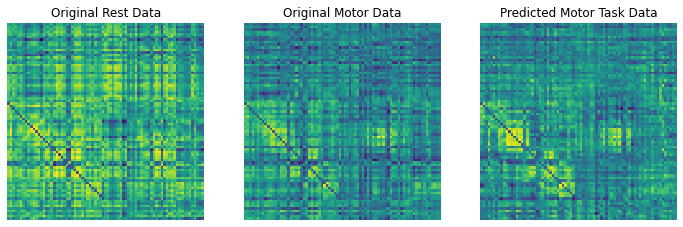

MSE: 0.036358799785375595
L1: 0.1493818759918213


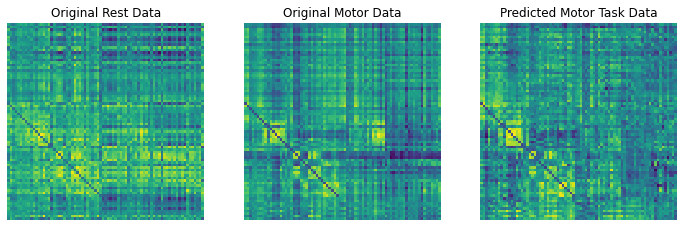

MSE: 0.04216485098004341
L1: 0.15808351337909698


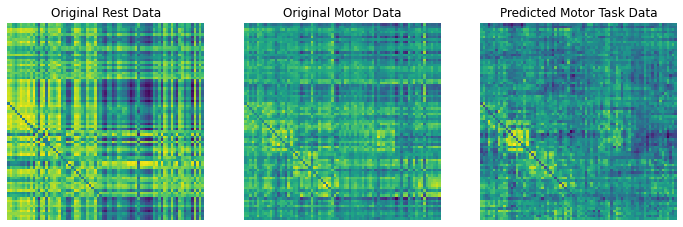

MSE: 0.04269411042332649
L1: 0.15948240458965302


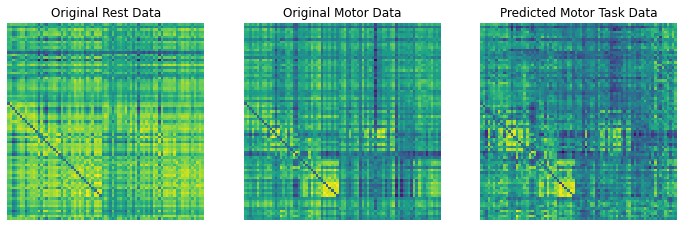

MSE: 0.035069338977336884
L1: 0.1472293883562088


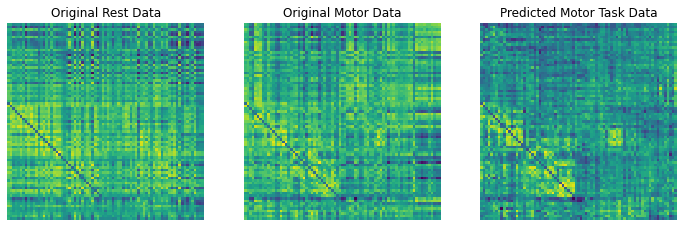

MSE: 0.03922109678387642
L1: 0.15355511009693146


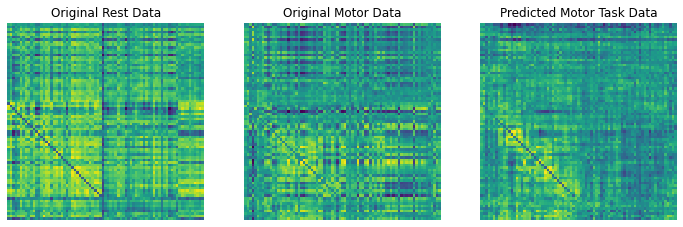

MSE: 0.03737952560186386
L1: 0.14828069508075714


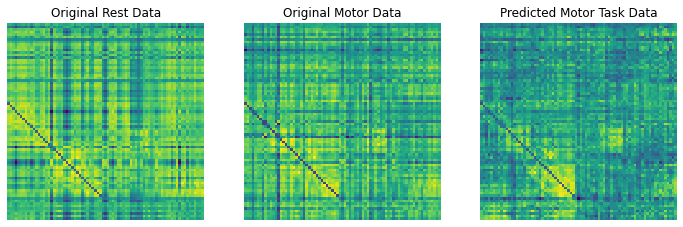

MSE: 0.048004716634750366
L1: 0.1676141619682312


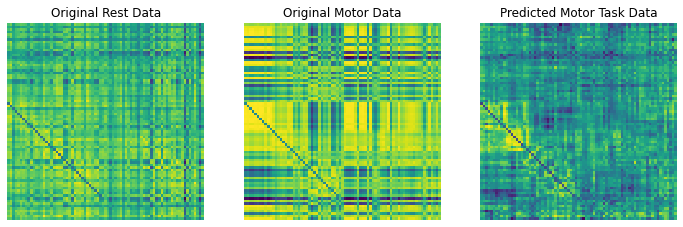

MSE: 0.05596506595611572
L1: 0.17777231335639954


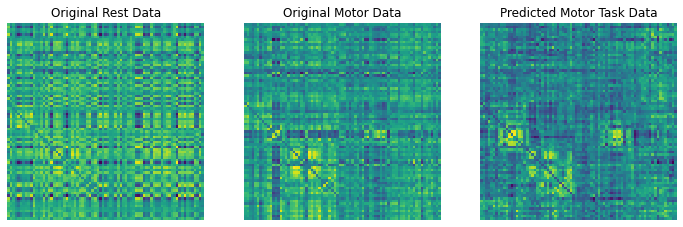

MSE: 0.06543280184268951
L1: 0.1928364783525467


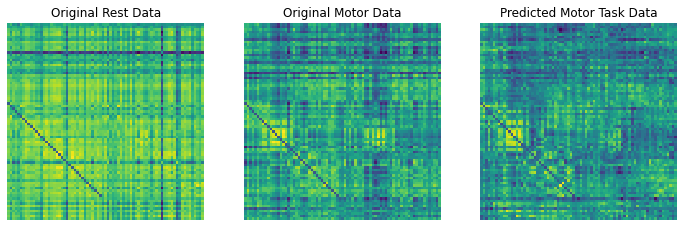

MSE: 0.051251377910375595
L1: 0.17547059059143066


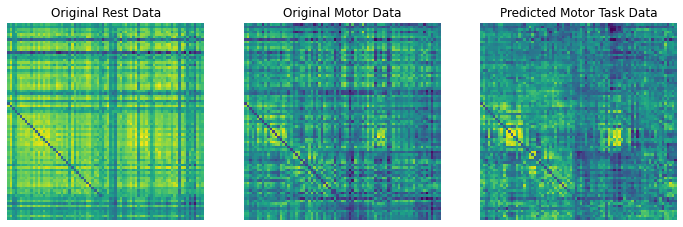

MSE: 0.0369938388466835
L1: 0.15158823132514954


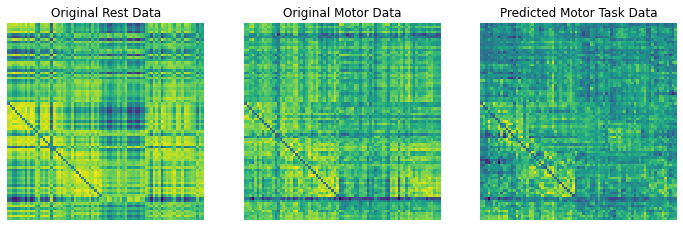

MSE: 0.03762320801615715
L1: 0.15025027096271515


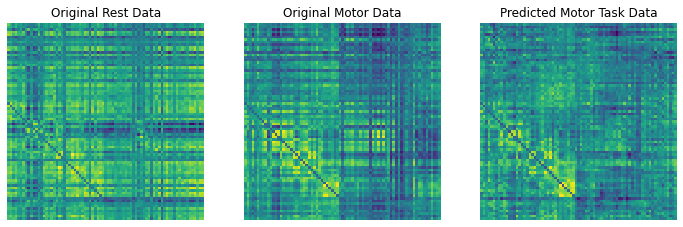

MSE: 0.03940362110733986
L1: 0.15565188229084015


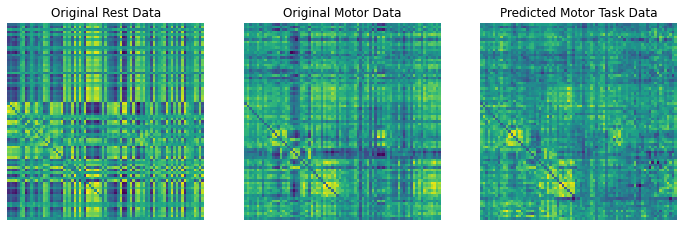

MSE: 0.03051680326461792
L1: 0.13592596352100372


In [34]:
L1Loss = torch.nn.L1Loss()

mse_loss_motor_all = []
l1_loss_motor_all = []
MSELoss = torch.nn.MSELoss()

with torch.no_grad():
    for batch_data in test_data_loader:
        rest_batch = batch_data["rest_fMRI_data"].to(device)  # Ensure data is on the same device as your model
        motor_batch = batch_data["motor_task_fMRI_data"].to(device)
        
        # Predict the motor task data
        T_X_test = generator(torch.tensor(motor_batch, device=device)).to(device)
        
        # Calculate the MSE loss
        mse_loss_motor = MSELoss(T_X_test, motor_batch)
        mse_loss_motor_all.append(mse_loss_motor.cpu().detach().numpy())
        
        # Calculate the L1 loss
        l1_loss_motor = L1Loss(T_X_test, motor_batch)
        l1_loss_motor_all.append(l1_loss_motor.cpu().detach().numpy())

        # Plot the original and predicted "motor" task data
        plot_original_and_predicted(rest_batch, motor_batch, T_X_test, 'Original Rest Data', 'Original Motor Data', 'Predicted Motor Task Data')
        
        # Print the losses
        print("MSE:", mse_loss_motor.item())
        print("L1:", l1_loss_motor.item())